In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
#from pandas.stats.api import ols
sns.set_style("darkgrid")
mpl.rcParams['figure.figsize'] = (20,5)
import math
from math import sqrt
from sklearn.preprocessing import StandardScaler
import datetime
import warnings
warnings.filterwarnings('ignore')

1. Test dataset doesnt has weekly sales information, so training dataset needs to be split in train and test for measuring prediction accuracty
[ We had a host of parameters listed in it e.g.
Temperature, Fuel Price, Promotional Markdowns 1-5, Inflation(CPI), Unemployment rate etc.
There were around 420,000 rows for the training set which made processing it very hard. Also,
as we did not have the real results of the test data in the file, we leveraged our training set and
divided it into 80:20 ratio to enable us to get a prediction accuracy for the model]

2. Data error - negative sales values need to be removed

In [3]:
#Step 1a: Data Load
features = pd.read_csv('features.csv.zip')
train = pd.read_csv('train.csv.zip')
stores = pd.read_csv('stores.csv')

In [4]:
dataset = train.merge(stores, how='left',on=['Store']).merge(features, how='left',on=['Store','Date','IsHoliday'])

In [5]:
dataset['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [6]:
#Step 1b: Data summary analysis
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


1. There are 421570 records in training dataset
2. There are 15 attributes out of which
   CPI (Inflation), Unemployment, Fuel_Price are economic indicators
   Temperature and IsHoliday are global variables
   Store, Dept, Type, Size, Markdowns are store-related variables

In [8]:
#Step 2a - EDA Univariate analysis
dataset.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000


In [9]:
#EDA Univariate - Store
print (dataset["Store"].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [10]:
#EDA Univariate - Department
print (dataset["Dept"].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52
 54 55 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94
 95 96 97 98 99 39 50 43 65]


In [11]:
#EDA Univariate - Store Type
print (dataset["Type"].unique())

['A' 'B' 'C']


In [12]:
#Converted store type labels A, B and C to 0, 1,2
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['Type'] = le.fit_transform(dataset['Type'])
dataset['IsHoliday'] = le.fit_transform(dataset['IsHoliday'])
dataset['IsHoliday'].unique()

array([0, 1], dtype=int64)

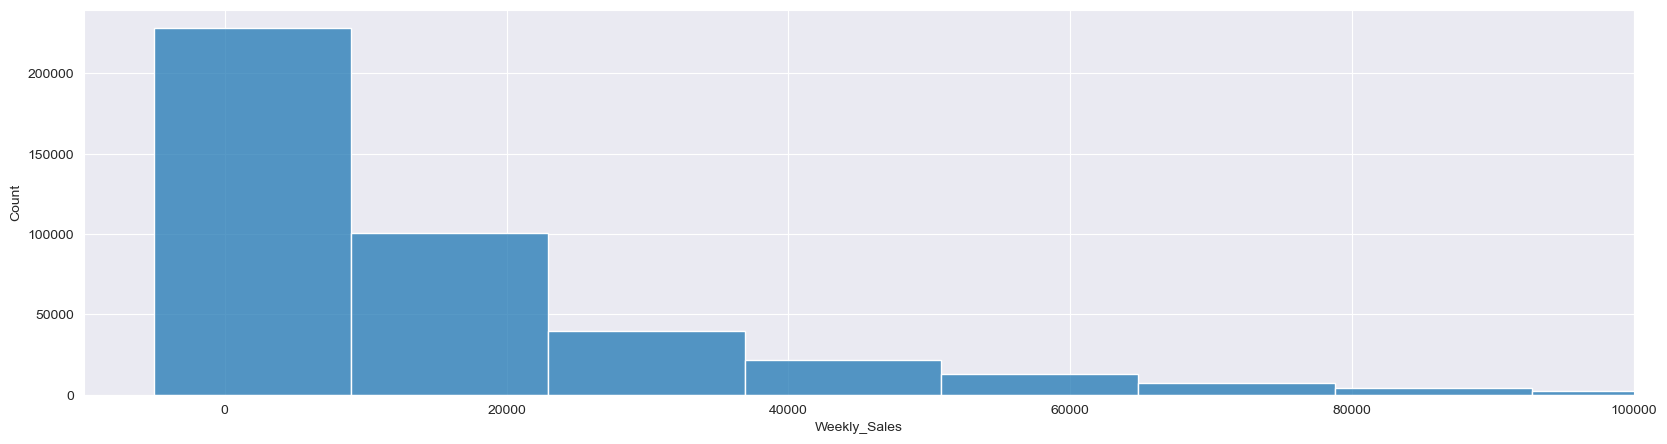

In [13]:
#EDA Univariate - Weekly sales
#There are negative values in weekly sales data that looks like data error, we need to cleanup data and remove them
#bins = np.linspace(x.m, x.max(), n_bins)
sns.histplot(data=dataset, bins=50, x="Weekly_Sales")
plt.xlim(-10000,100000)
plt.show()

In [14]:
#Dropping weekly sales values less than 0
dataset_f = dataset.loc[(dataset['Weekly_Sales']>=0)]

(-10000.0, 100000.0)

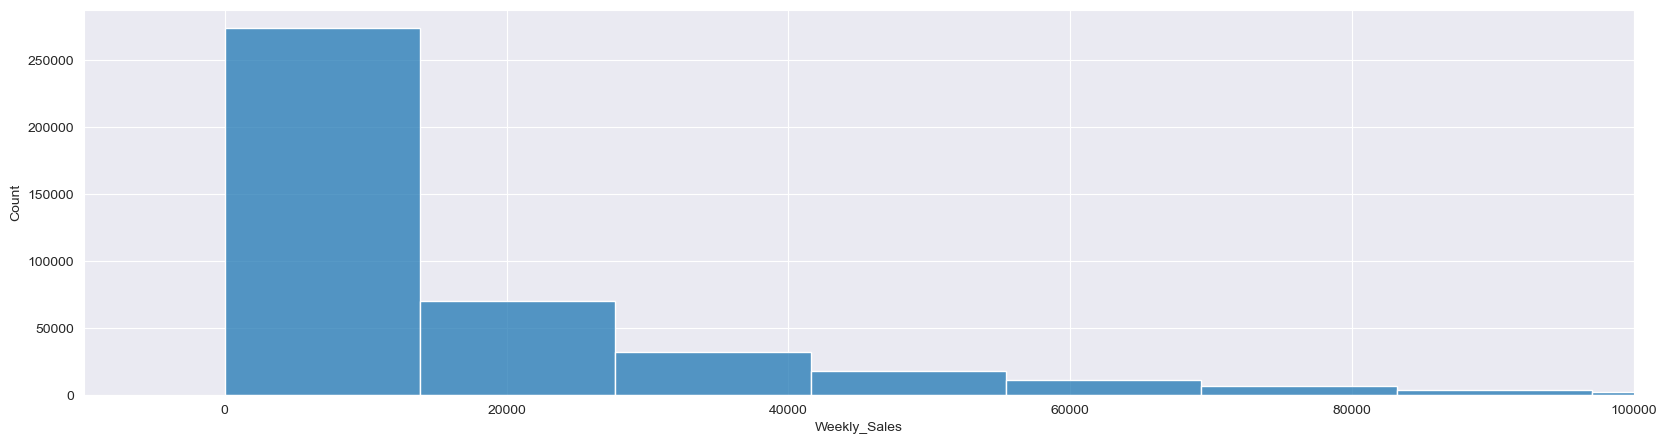

In [15]:
sns.histplot(data=dataset_f, bins=50, x="Weekly_Sales")
plt.xlim(-10000,100000)

### Univariate data analysis
1. There are 45 Stores in the dataset
2. There are 99 Departments
3. There are three store types - A, B, C. We will convert these categorical variables to dummy variables for modeling

### Bivariate analysis
1. Group by store, department and show sales

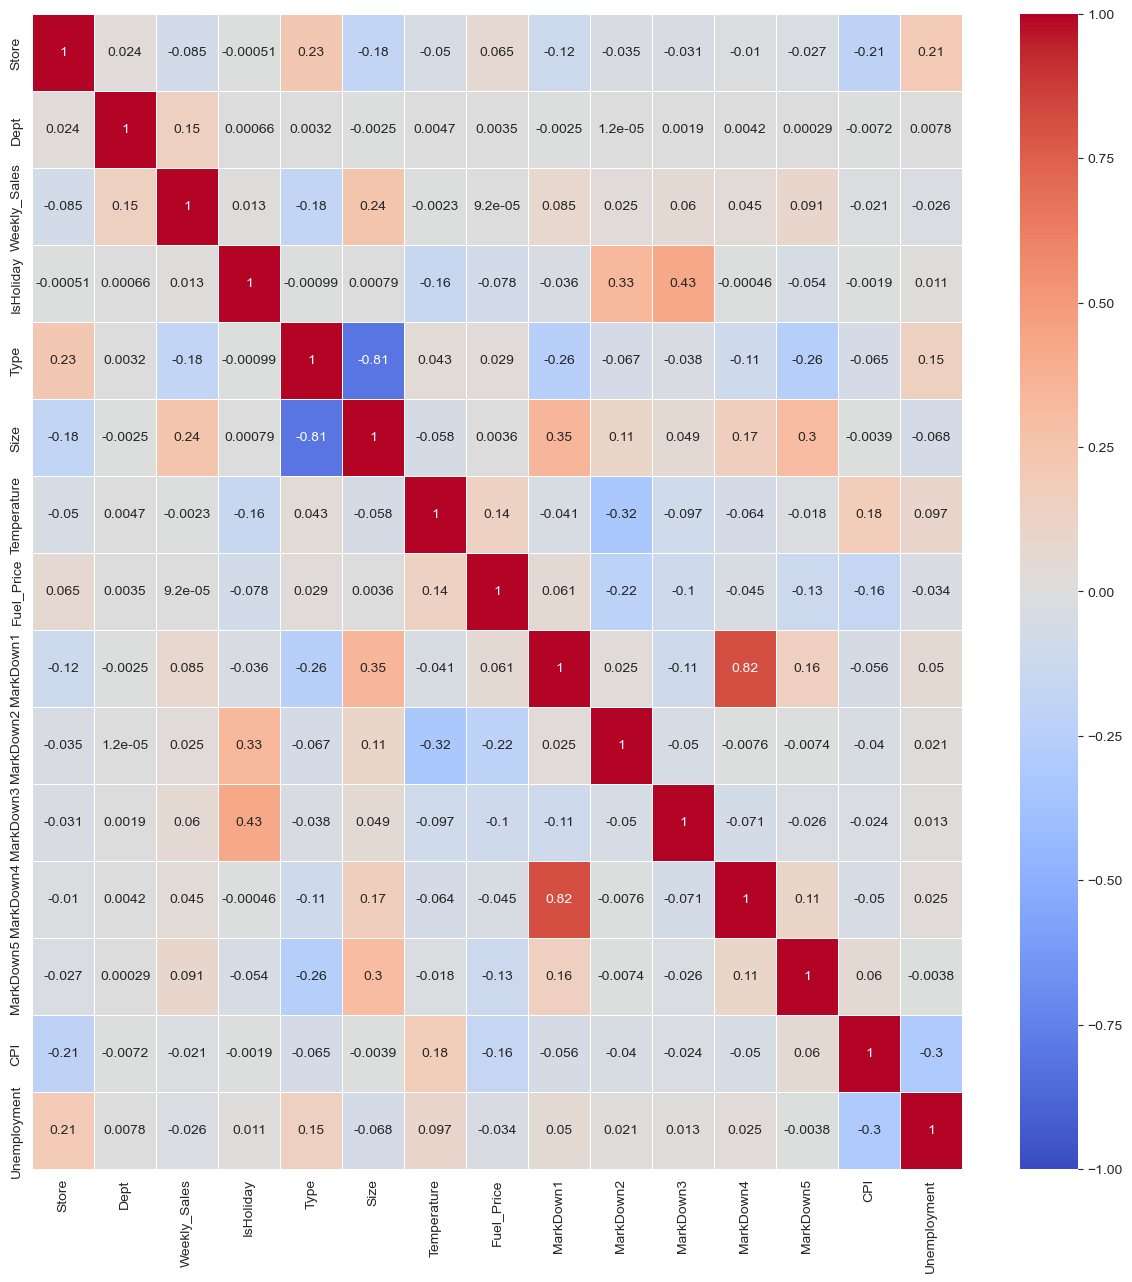

In [18]:
### Multivariate analysis

numeric_data = dataset_f.select_dtypes(include=[float, int])

corr = numeric_data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.show()

### based on multivariat analysis we conclude that
1. Store type correlates highly wiht store size, so we can go with store size
2. Markdown 1 correlates highly wiht Markdown4, so we can choose only one of them
3. Fuel price and temperature can be dropped

In [20]:
dataset_f['Date']

0         2010-02-05
1         2010-02-12
2         2010-02-19
3         2010-02-26
4         2010-03-05
             ...    
421565    2012-09-28
421566    2012-10-05
421567    2012-10-12
421568    2012-10-19
421569    2012-10-26
Name: Date, Length: 420285, dtype: object

In [21]:
dataset_f[['Year', 'Month', 'Date']] = dataset_f['Date'].apply(lambda x: x.split('-')).apply(pd.Series)

In [22]:
dataset_f.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month
0,1,1,05,24924.50,0,0,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,02
1,1,1,12,46039.49,1,0,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,02
2,1,1,19,41595.55,0,0,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,02
3,1,1,26,19403.54,0,0,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,02
4,1,1,05,21827.90,0,0,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,03


In [23]:
#We don't need store id for modeling, so drop it
dataset_f2 = dataset_f[['Year', 'Month', 'Date', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Size', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'CPI', 'Unemployment']]


In [24]:
dataset_f2.head()

,Year,Month,Date,Dept,Date,Weekly_Sales,IsHoliday,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,CPI,Unemployment
0,2010,02,05,1,05,24924.50,0,151315,NaN,NaN,NaN,NaN,211.096358,8.106
1,2010,02,12,1,12,46039.49,1,151315,NaN,NaN,NaN,NaN,211.242170,8.106
2,2010,02,19,1,19,41595.55,0,151315,NaN,NaN,NaN,NaN,211.289143,8.106
3,2010,02,26,1,26,19403.54,0,151315,NaN,NaN,NaN,NaN,211.319643,8.106
4,2010,03,05,1,05,21827.90,0,151315,NaN,NaN,NaN,NaN,211.350143,8.106


In [25]:
dataset_f2.fillna(0, inplace=True)

In [26]:
dataset_f2.tail()

,Year,Month,Date,Dept,Date,Weekly_Sales,IsHoliday,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,CPI,Unemployment
421565,2012,09,28,98,28,508.37,0,118221,4556.61,20.64,1.50,1601.01,192.013558,8.684
421566,2012,10,05,98,05,628.10,0,118221,5046.74,0.00,18.82,2253.43,192.170412,8.667
421567,2012,10,12,98,12,1061.02,0,118221,1956.28,0.00,7.89,599.32,192.327265,8.667
421568,2012,10,19,98,19,760.01,0,118221,2004.02,0.00,3.18,437.73,192.330854,8.667
421569,2012,10,26,98,26,1076.80,0,118221,4018.91,58.08,100.00,211.94,192.308899,8.667


## With the selected features, do the modeling
### 1. Scale the data StandardScalar
### 2. Test train split, 80-20
### 3. Regression model
### 4. Performance metrics

In [28]:
scaler = StandardScaler()
scaled_dataset= scaler.fit_transform(dataset_f2)

In [29]:
scaled_dataset_df = pd.DataFrame(scaled_dataset, columns = dataset_f2.columns)

In [30]:
scaled_dataset_df.head()

,Year,Month,Date,Dept,Date,Weekly_Sales,IsHoliday,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,CPI,Unemployment
0,-1.215275,-1.371932,-1.219484,-1.417463,-1.219484,0.391323,-0.275068,0.238806,-0.427903,-0.173111,-0.084714,-0.278111,1.018435,0.07829
1,-1.215275,-1.371932,-0.419741,-1.417463,-0.419741,1.320333,3.635463,0.238806,-0.427903,-0.173111,-0.084714,-0.278111,1.022159,0.07829
2,-1.215275,-1.371932,0.380001,-1.417463,0.380001,1.124810,-0.275068,0.238806,-0.427903,-0.173111,-0.084714,-0.278111,1.023358,0.07829
3,-1.215275,-1.371932,1.179744,-1.417463,1.179744,0.148413,-0.275068,0.238806,-0.427903,-0.173111,-0.084714,-0.278111,1.024137,0.07829
4,-1.215275,-1.063612,-1.219484,-1.417463,-1.219484,0.255080,-0.275068,0.238806,-0.427903,-0.173111,-0.084714,-0.278111,1.024916,0.07829


In [31]:
X = dataset_f2[['Year', 'Month', 'Date', 'Dept', 'Date','IsHoliday', 'Size', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'CPI', 'Unemployment']]
y = dataset_f2["Weekly_Sales"]

In [32]:
#Train  test split
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=104,test_size=0.2, shuffle=True)

### Regression and Forecasting
## We will use three methods 
# 1. Linear Regression
# 2. Polynomila Regression
# 3. XGBoost

In [34]:
## Linear Regression

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

print("MSE",mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)
print(r2)
#yy = y_train.values.tolist()
#XX = X_train.values.tolist()
#result = sm.OLS(yy,XX).fit()

# printing the summary table
#print(result.summary())

MSE 472685374.7649597
0.0855212183217805


In [35]:
## Polynomial regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
poly = PolynomialFeatures(degree=3)

X_poly_train = poly.fit_transform(X_train)
#X_test_poly = poly.transform(X_test)
poly.fit(X_poly_train,y_train)

lin = LinearRegression()
lin.fit(X_poly_train, y_train)

y_pred =lin.predict(poly.fit_transform(X_test))
print("MSE",mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)
print(r2)

MSE 394907965.2807823
0.2359929580123632


In [36]:
# XGBoost
from numpy import absolute
#from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
# load the dataset
#url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
#dataframe = read_csv(url, header=None)
#data = dataframe.values
# split data into input and output columns
#X, y = data[:, :-1], data[:, -1]
X = X_train.values
y = y_train.values
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )


#model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)


Mean MAE: 3338.709 (45.905)


In [37]:
model.fit(X,y)
y_pred = model.predict(X_test.values)

In [38]:
r2 = r2_score(y_test,y_pred)

In [39]:
r2

0.9331003768121471